# Water Quality and Potability Classification
  
#### [Dataset URL](https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability)
  
## Opis zbioru danych

Ten zbiór danych zawiera pomiary jakości wody oraz oceny dotyczące jej zdatności do spożycia przez ludzi, czyli potencjał pitności. Głównym celem tego zbioru danych jest dostarczenie wglądu w parametry jakości wody i pomoc w określeniu, czy woda jest zdatna do spożycia. Każdy wiersz w zbiorze danych reprezentuje próbkę wody z określonymi cechami, a kolumna "Potability" wskazuje, czy woda jest odpowiednia do spożycia. Głównym celem tego zbioru danych jest ocena i przewidywanie potencjału potabilności wody na podstawie cech jakości wody. Może być używany do oceny bezpieczeństwa i odpowiedniości źródeł wody do spożycia przez ludzi, podejmowania świadomych decyzji dotyczących uzdatniania wody oraz zapewnienia zgodności z normami jakości wody.

## Opis cech

- pH: Poziom pH wody.
- Hardness: Twardość wody, miara zawartości minerałów.
- Solids: Całkowita zawartość substancji rozpuszczonych w wodzie.
- Chloramines: Stężenie chloramin w wodzie.
- Sulfate: Stężenie siarczanów w wodzie.
- Conductivity: Przewodność elektryczna wody.
- Organic_carbon: Zawartość węgla organicznego w wodzie.
- Trihalomethanes: Stężenie trihalometanów w wodzie.
- Turbidity: Poziom mętności, miara klarowności wody.
- Potability: Zmienna celu; wskazuje zdatność do spożycia wody, przyjmując wartości 1 (zdatna do spożycia - "potable") i 0 (niezdatna do spożycia - "not potable).

## Parametry zbioru danych

- Liczba rekordów: 3276
- Liczba cech: 9
- Dane brakujące: Tak (kolumny: pH, Sulfate and Trihalomethanes)
- Dane odstające: Tak (ok. 1.22% całego zbioru danych) 
- Typ problemu: Klasyfikacja (Potability - No (0), Yes (1))

## Rozkład klas

| Klasa | Liczba rekordów | Rozkład procentowy |
|-------|-----------------|--------------------|
| 0     | 1998            | 60.99%             |
| 1     | 1278            | 39.01%             |

## Importowanie bibliotek

In [46]:
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

## Załadowanie zmiennych

Zmienne zostają załadowane z pliku wygenerowanego z notebooka DataAnalysis.ipynb przy pomocy biblioteki pickle, służącej do serializacji oraz deserializacji danych. Wybrano dane, które osiągnęły najlepsze wyniki podczas 2 etapu - tworzenia i trenowania modeli.

In [47]:
with open('data_dump/normalizedStdInterpolateVars.pkl', 'rb') as f:
    normalized_std_interpolate = pickle.load(f)
    scaler_std_interpolate = pickle.load(f)

## Ustawienie ziarna losowości

In [48]:
random_seed = 731202496
random.seed(random_seed)

## Funkcje do podziału zbioru danych

Utworzono dwie funkcje do tworzenia podziału danych. Split_df_train_test odpowiada za podział danych na dwa zbiory: testowy i treningowy. Dane są dzielone z równomiernym podziałem klas, aby zapobiec sytuacji, w której podczas podziału danych, przydzielono do zbioru treningowego tylko jedną klasę danych. 

In [49]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)

    unique_labels = data['Potability'].unique()
    label_counts = data['Potability'].value_counts()

    test_indices = []

    for label in unique_labels:
        num_label_samples = label_counts[label]
        num_test_samples = int(test_size * num_label_samples)
        label_indices = data.index[data['Potability'] == label].tolist()
        label_test_indices = np.random.choice(label_indices, size=num_test_samples, replace=False)
        test_indices.extend(label_test_indices)

    train_indices = np.setdiff1d(data.index, test_indices)

    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]

    return train_set, test_set

### Funkcje pomocniczne do obliczania F1 score oraz rysowania macierzy pomyłek

In [50]:
def calculate_f1_score(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))

    epsilon = 1e-7 
    precision_positives = true_positives / (true_positives + false_positives + epsilon)
    recall_positives = true_positives / (true_positives + false_negatives + epsilon)
    f1_score_positives = 2 * (precision_positives * recall_positives) / (precision_positives + recall_positives + epsilon)

    precision_negatives = true_negatives / (true_negatives + false_negatives + epsilon)
    recall_negatives = true_negatives / (true_negatives + false_positives + epsilon)
    f1_score_negatives = 2 * (precision_negatives * recall_negatives) / (precision_negatives + recall_negatives + epsilon)

    f1_score = (f1_score_positives + f1_score_negatives) / 2
    return f1_score

def plot_model_confusion_matrix(ax, model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(f'{model_name}')

### Split danych

Podzielenie danych przy pomocy funkcji "split_df_train_test"

In [51]:
train_std_interpolate, test_std_interpolate = split_df_train_test(normalized_std_interpolate, 0.2, 123)

### Podział klas po splicie - test/train

In [52]:
train_class_counts = train_std_interpolate['Potability'].value_counts(normalize=True) * 100
test_class_counts = test_std_interpolate['Potability'].value_counts(normalize=True) * 100

print("Train set:")
print(train_class_counts)
print("\nTest set:")
print(test_class_counts)

Train set:
Potability
0    60.983982
1    39.016018
Name: proportion, dtype: float64

Test set:
Potability
0    61.009174
1    38.990826
Name: proportion, dtype: float64


## Random Forest - Scikit-Learn

In [53]:
class RandomForestClassifierWrapper:

    def __init__(self, train_set, test_set, optimize_f1_score, optimization_method):
        self.classifier_name = "Random Forest"
        self.optimization_method = optimization_method
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.test_pred = None
        self.hof = None
        self.best_optuna_trial = None
        self.best_score = None
        self.best_score_type = "F1 score" if optimize_f1_score else "accuracy"
        self.best_params = None
        self.processing_time = None
        self._create_model()

    # ----------------- DEAP -----------------
    def deap_objective(self, individual):
        n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion = individual
        n_estimators = int(n_estimators)
        max_depth = int(max_depth) if max_depth > 0 else None
        min_samples_split = int(min_samples_split) if int(min_samples_split) > 1 else 2
        min_samples_leaf = int(min_samples_leaf) if int(min_samples_leaf) > 0 else 1
        bootstrap = bool(bootstrap)
        criterion = 'gini' if criterion < 0.5 else 'entropy'
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       bootstrap=bootstrap, criterion=criterion, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score,

    def train_model_with_ga(self):
        if not hasattr(creator, 'FitnessMax'):
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        if not hasattr(creator, 'Individual'):
            creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_n_estimators", random.randint, 10, 200)
        toolbox.register("attr_max_depth", random.randint, 1, 50)
        toolbox.register("attr_min_samples_split", random.randint, 2, 10)
        toolbox.register("attr_min_samples_leaf", random.randint, 1, 10)
        toolbox.register("attr_bootstrap", random.randint, 0, 1)
        toolbox.register("attr_criterion", random.uniform, 0, 1)

        toolbox.register("individual", tools.initCycle, creator.Individual,
                         (toolbox.attr_n_estimators, toolbox.attr_max_depth, toolbox.attr_min_samples_split,
                          toolbox.attr_min_samples_leaf, toolbox.attr_bootstrap, toolbox.attr_criterion), n=1)

        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", self.deap_objective)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=5)

        pop = toolbox.population(n=100)

        self.hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=30, lambda_=50, cxpb=0.5, mutpb=0.2,
                                                 ngen=5,
                                                 stats=stats, halloffame=self.hof, verbose=True)

        best_individual = tools.selBest(pop, 1)[0]

        self.model = RandomForestClassifier(n_estimators=int(best_individual[0]),
                                            max_depth=int(best_individual[1]),
                                            min_samples_split=int(
                                                best_individual[2] if int(best_individual[2]) > 1 else 2),
                                            min_samples_leaf=int(
                                                best_individual[3] if int(best_individual[3]) > 0 else 1),
                                            bootstrap=bool(best_individual[4]),
                                            criterion='gini' if best_individual[5] < 0.5 else 'entropy',
                                            random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_deap()

    def save_best_params_deap(self):
        self.best_params = {
            "n_estimators": int(self.hof[0][0]),
            "max_depth": int(self.hof[0][1]),
            "min_samples_split": int(self.hof[0][2]),
            "min_samples_leaf": int(self.hof[0][3]),
            "bootstrap": bool(self.hof[0][4]),
            "criterion": 'gini' if self.hof[0][5] < 0.5 else 'entropy'
        }

    # ----------------- Optuna -----------------
    def optuna_objective(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 1, 50)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        bootstrap = trial.suggest_categorical("bootstrap", [True, False])
        criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])

        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       bootstrap=bootstrap, criterion=criterion, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score

    def train_model_with_optuna(self, n_trials=100):
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: self.optuna_objective(trial), n_jobs=-1, n_trials=n_trials)

        self.best_optuna_trial = study.best_trial

        self.model = RandomForestClassifier(n_estimators=self.best_optuna_trial.params["n_estimators"],
                                            max_depth=self.best_optuna_trial.params["max_depth"],
                                            min_samples_split=self.best_optuna_trial.params["min_samples_split"],
                                            min_samples_leaf=self.best_optuna_trial.params["min_samples_leaf"],
                                            bootstrap=self.best_optuna_trial.params["bootstrap"],
                                            criterion=self.best_optuna_trial.params["criterion"],
                                            random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_optuna()

    def save_best_params_optuna(self):
        self.best_params = {
            "n_estimators": int(self.best_optuna_trial.params["n_estimators"]),
            "max_depth": int(self.best_optuna_trial.params["max_depth"]),
            "min_samples_split": int(self.best_optuna_trial.params["min_samples_split"]),
            "min_samples_leaf": int(self.best_optuna_trial.params["min_samples_leaf"]),
            "bootstrap": bool(self.best_optuna_trial.params["bootstrap"]),
            "criterion": self.best_optuna_trial.params["criterion"]
        }

    # ----------------- RandomizedSearchCV -----------------
    def train_model_CV(self):
        param_distributions = {
            "n_estimators": list(range(10, 201)),
            "max_depth": [None] + list(range(1, 51)),
            "min_samples_split": list(range(2, 11)),
            "min_samples_leaf": list(range(1, 11)),
            "bootstrap": [True, False],
            "criterion": ['gini', 'entropy']
        }

        if self.best_score_type == "F1 score":
            scoring = 'f1'
        else:
            scoring = 'accuracy'

        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, scoring=scoring,
                                           n_iter=12, cv=5, random_state=random_seed, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model_CV(self):
        self.set_best_score()
        self.save_best_params_CV()

    def set_best_score(self):
        self.test_pred = self.model.predict(self.test_set)
        if self.best_score_type == "F1 score":
            self.best_score = calculate_f1_score(self.test_label, self.test_pred)
        else:
            self.best_score = accuracy_score(self.test_label, self.test_pred)

    def save_best_params_CV(self):
        self.best_params = {
            "n_estimators": int(self.model.get_params()['n_estimators']),
            "max_depth": int(self.model.get_params()['max_depth']),
            "min_samples_split": int(self.model.get_params()['min_samples_split']),
            "min_samples_leaf": int(self.model.get_params()['min_samples_leaf']),
            "bootstrap": bool(self.model.get_params()['bootstrap']),
            "criterion": self.model.get_params()['criterion']
        }

    # ----------------- Other -----------------
    def _create_model(self):
        self.model = RandomForestClassifier(random_state=random_seed)

    def set_processing_time(self, end, start):
        self.processing_time = end - start

### XGBoost

In [54]:
class XGBoostClassifierWrapper:

    def __init__(self, train_set, test_set, optimize_f1_score, optimization_method):
        self.classifier_name = "XGBoost"
        self.optimization_method = optimization_method
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.test_pred = None
        self.hof = None
        self.best_optuna_trial = None
        self.best_score = None
        self.best_score_type = "F1 score" if optimize_f1_score else "accuracy"
        self.best_params = None
        self.processing_time = None
        self._create_model()

    # ----------------- DEAP -----------------
    def deap_objective(self, individual):
        n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, learning_rate, reg_lambda, reg_alpha = individual
        n_estimators = int(n_estimators)
        max_depth = int(max_depth) if max_depth > 0 else None
        min_child_weight = int(min_child_weight) if int(min_child_weight) > 0 else 1
        gamma = max(0, gamma)
        subsample = min(max(0.1, subsample), 1)
        colsample_bytree = min(max(0.1, colsample_bytree), 1)
        learning_rate = min(max(0.01, learning_rate), 1)
        reg_lambda = max(0, reg_lambda)
        reg_alpha = max(0, reg_alpha)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_child_weight=min_child_weight, gamma=gamma,
                                  subsample=subsample, colsample_bytree=colsample_bytree,
                                  learning_rate=learning_rate, reg_lambda=reg_lambda,
                                  reg_alpha=reg_alpha, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score,

    def train_model_with_ga(self):
        if not hasattr(creator, 'FitnessMax'):
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        if not hasattr(creator, 'Individual'):
            creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()

        toolbox.register("attr_n_estimators", random.randint, 10, 200)
        toolbox.register("attr_max_depth", random.randint, 1, 50)
        toolbox.register("attr_min_child_weight", random.randint, 1, 10)
        toolbox.register("attr_gamma", random.uniform, 0, 1)
        toolbox.register("attr_subsample", random.uniform, 0.1, 1)
        toolbox.register("attr_colsample_bytree", random.uniform, 0.1, 1)
        toolbox.register("attr_learning_rate", random.uniform, 0.01, 1)
        toolbox.register("attr_reg_lambda", random.uniform, 0, 1)
        toolbox.register("attr_reg_alpha", random.uniform, 0, 1)

        toolbox.register("individual", tools.initCycle, creator.Individual,
                         (toolbox.attr_n_estimators, toolbox.attr_max_depth, toolbox.attr_min_child_weight,
                          toolbox.attr_gamma, toolbox.attr_subsample, toolbox.attr_colsample_bytree,
                          toolbox.attr_learning_rate, toolbox.attr_reg_lambda, toolbox.attr_reg_alpha), n=1)

        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        toolbox.register("evaluate", self.deap_objective)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=5)

        pop = toolbox.population(n=100)

        self.hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=30, lambda_=50, cxpb=0.5, mutpb=0.2,
                                                 ngen=5,
                                                 stats=stats, halloffame=self.hof, verbose=True)

        best_individual = tools.selBest(pop, 1)[0]

        self.model = xgb.XGBClassifier(n_estimators=int(best_individual[0]),
                                       max_depth=int(best_individual[1]),
                                       min_child_weight=int(best_individual[2] if int(best_individual[2]) > 0 else 1),
                                       gamma=max(0, best_individual[3]),
                                       subsample=min(max(0.1, best_individual[4]), 1),
                                       colsample_bytree=min(max(0.1, best_individual[5]), 1),
                                       learning_rate=min(max(0.01, best_individual[6]), 1),
                                       reg_lambda=max(0, best_individual[7]),
                                       reg_alpha=max(0, best_individual[8]),
                                       random_state=random_seed)

        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_deap()

    def save_best_params_deap(self):
        self.best_params = {
            "n_estimators": int(self.hof[0][0]),
            "max_depth": int(self.hof[0][1]),
            "min_child_weight": int(self.hof[0][2]),
            "gamma": self.hof[0][3],
            "subsample": self.hof[0][4],
            "colsample_bytree": self.hof[0][5],
            "learning_rate": self.hof[0][6],
            "reg_lambda": self.hof[0][7],
            "reg_alpha": self.hof[0][8]
        }

    # ----------------- Optuna -----------------
    def optuna_objective(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 1, 50)
        min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
        gamma = trial.suggest_float("gamma", 0, 1)
        subsample = trial.suggest_float("subsample", 0.1, 1)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
        reg_lambda = trial.suggest_float("reg_lambda", 0, 1)
        reg_alpha = trial.suggest_float("reg_alpha", 0, 1)

        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                  min_child_weight=min_child_weight, gamma=gamma,
                                  subsample=subsample, colsample_bytree=colsample_bytree,
                                  learning_rate=learning_rate, reg_lambda=reg_lambda,
                                  reg_alpha=reg_alpha, random_state=random_seed)
        model.fit(self.train_set, self.train_label)
        predictions = model.predict(self.test_set)

        if self.best_score_type == "F1 score":
            score = calculate_f1_score(self.test_label, predictions)
        else:
            score = accuracy_score(self.test_label, predictions)

        return score

    def train_model_with_optuna(self, n_trials=100):
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: self.optuna_objective(trial), n_jobs=-1, n_trials=n_trials)

        self.best_optuna_trial = study.best_trial

        self.model = xgb.XGBClassifier(n_estimators=self.best_optuna_trial.params["n_estimators"],
                                       max_depth=self.best_optuna_trial.params["max_depth"],
                                       min_child_weight=self.best_optuna_trial.params["min_child_weight"],
                                       gamma=self.best_optuna_trial.params["gamma"],
                                       subsample=self.best_optuna_trial.params["subsample"],
                                       colsample_bytree=self.best_optuna_trial.params["colsample_bytree"],
                                       learning_rate=self.best_optuna_trial.params["learning_rate"],
                                       reg_lambda=self.best_optuna_trial.params["reg_lambda"],
                                       reg_alpha=self.best_optuna_trial.params["reg_alpha"],
                                       random_state=random_seed)
        self.model.fit(self.train_set, self.train_label)
        self.set_best_score()
        self.save_best_params_optuna()

    def save_best_params_optuna(self):
        self.best_params = {
            "n_estimators": int(self.best_optuna_trial.params["n_estimators"]),
            "max_depth": int(self.best_optuna_trial.params["max_depth"]),
            "min_child_weight": int(self.best_optuna_trial.params["min_child_weight"]),
            "gamma": self.best_optuna_trial.params["gamma"],
            "subsample": self.best_optuna_trial.params["subsample"],
            "colsample_bytree": self.best_optuna_trial.params["colsample_bytree"],
            "learning_rate": self.best_optuna_trial.params["learning_rate"],
            "reg_lambda": self.best_optuna_trial.params["reg_lambda"],
            "reg_alpha": self.best_optuna_trial.params["reg_alpha"]
        }

    # ----------------- RandomizedSearchCV -----------------
    def train_model_CV(self):
        param_distributions = {
            "n_estimators": list(range(10, 201)),
            "max_depth": list(range(1, 51)),
            "min_child_weight": list(range(1, 11)),
            "gamma": [i / 10.0 for i in range(0, 5)],
            "subsample": [i / 10.0 for i in range(6, 10)],
            "colsample_bytree": [i / 10.0 for i in range(6, 10)],
            "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3],
            "reg_lambda": [i / 10.0 for i in range(0, 5)],
            "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]
        }

        if self.best_score_type == "F1 score":
            scoring = 'f1'
        else:
            scoring = 'accuracy'

        random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, scoring=scoring,
                                           n_iter=12, cv=5, random_state=random_seed, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model_CV(self):
        self.set_best_score()
        self.save_best_params_CV()

    def set_best_score(self):
        self.test_pred = self.model.predict(self.test_set)
        if self.best_score_type == "F1 score":
            self.best_score = calculate_f1_score(self.test_label, self.test_pred)
        else:
            self.best_score = accuracy_score(self.test_label, self.test_pred)

    def save_best_params_CV(self):
        self.best_params = {
            "n_estimators": int(self.model.get_params()['n_estimators']),
            "max_depth": int(self.model.get_params()['max_depth']),
            "min_child_weight": int(self.model.get_params()['min_child_weight']),
            "gamma": self.model.get_params()['gamma'],
            "subsample": self.model.get_params()['subsample'],
            "colsample_bytree": self.model.get_params()['colsample_bytree'],
            "learning_rate": self.model.get_params()['learning_rate'],
            "reg_lambda": self.model.get_params()['reg_lambda'],
            "reg_alpha": self.model.get_params()['reg_alpha']
        }

    # ----------------- Other -----------------
    def _create_model(self):
        self.model = xgb.XGBClassifier(random_state=random_seed)

    def set_processing_time(self, end, start):
        self.processing_time = end - start

### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą algorytmu genetycznego

In [55]:
start_time = time.time()
RF_model_accuracy_optimizing_DEAP = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                  optimize_f1_score=False, optimization_method="DEAP")
RF_model_accuracy_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
RF_model_accuracy_optimizing_DEAP.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_DEAP = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                 optimize_f1_score=True, optimization_method="DEAP")
RF_model_f1score_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
RF_model_f1score_optimizing_DEAP.set_processing_time(end_time, start_time)

gen	nevals	avg     	min     	max     
0  	100   	0.671422	0.610092	0.692661
1  	38    	0.684913	0.675841	0.692661
2  	36    	0.689042	0.686544	0.692661
3  	33    	0.692966	0.688073	0.700306
4  	38    	0.696126	0.692661	0.700306
5  	37    	0.698216	0.692661	0.700306
gen	nevals	avg     	min     	max     
0  	100   	0.589964	0.378917	0.642742
1  	33    	0.629281	0.579601	0.642742
2  	32    	0.638186	0.624936	0.650082
3  	33    	0.641662	0.636933	0.652348
4  	36    	0.646462	0.642742	0.653665
5  	38    	0.65108 	0.645642	0.653665


### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą biblioteki Optuna

In [56]:
start_time = time.time()
RF_model_accuracy_optimizing_optuna = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                    optimize_f1_score=False, optimization_method="Optuna")
RF_model_accuracy_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
RF_model_accuracy_optimizing_optuna.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_optuna = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                   optimize_f1_score=True, optimization_method="Optuna")
RF_model_f1score_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
RF_model_f1score_optimizing_optuna.set_processing_time(end_time, start_time)

[I 2024-06-08 14:26:50,004] A new study created in memory with name: no-name-be233c09-0dd0-43fa-9098-78a5b2a29e7d
[I 2024-06-08 14:26:50,898] Trial 17 finished with value: 0.672782874617737 and parameters: {'n_estimators': 13, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 10, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 17 with value: 0.672782874617737.
[I 2024-06-08 14:26:51,526] Trial 20 finished with value: 0.6498470948012233 and parameters: {'n_estimators': 22, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 17 with value: 0.672782874617737.
[I 2024-06-08 14:26:52,064] Trial 0 finished with value: 0.6819571865443425 and parameters: {'n_estimators': 43, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6819571865443425.
[I 2024-06-08 14:26:53,035] Trial 9 finished with value: 0.6559633027522935 and 

### Trenowanie modelu Random Forest - optymalizacja hiperparametrów za pomocą RandomizedSearchCV

In [57]:
start_time = time.time()
RF_model_accuracy_optimizing_CV = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                optimize_f1_score=False, optimization_method="RandomizedSearchCV")
RF_model_accuracy_optimizing_CV.train_model_CV()
RF_model_accuracy_optimizing_CV.evaluate_model_CV()
end_time = time.time()
RF_model_accuracy_optimizing_CV.set_processing_time(end_time, start_time)

start_time = time.time()
RF_model_f1score_optimizing_CV = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                               optimize_f1_score=True, optimization_method="RandomizedSearchCV")
RF_model_f1score_optimizing_CV.train_model_CV()
RF_model_f1score_optimizing_CV.evaluate_model_CV()
end_time = time.time()
RF_model_f1score_optimizing_CV.set_processing_time(end_time, start_time)

### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą algorytmu genetycznego

In [58]:
start_time = time.time()
XGB_model_accuracy_optimizing_DEAP = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                              optimize_f1_score=False, optimization_method="DEAP")
XGB_model_accuracy_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
XGB_model_accuracy_optimizing_DEAP.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_DEAP = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                             optimize_f1_score=True, optimization_method="DEAP")
XGB_model_f1score_optimizing_DEAP.train_model_with_ga()
end_time = time.time()
XGB_model_f1score_optimizing_DEAP.set_processing_time(end_time, start_time)

gen	nevals	avg     	min     	max     
0  	100   	0.599343	0.513761	0.674312
1  	31    	0.635678	0.597859	0.663609
2  	34    	0.652701	0.610092	0.663609
3  	34    	0.658257	0.639144	0.665138
4  	34    	0.662895	0.66055 	0.666667
5  	31    	0.66682 	0.66055 	0.675841
gen	nevals	avg     	min     	max     
0  	100   	0.558442	0.451457	0.631992
1  	30    	0.602188	0.557879	0.626738
2  	41    	0.615805	0.59152 	0.633393
3  	37    	0.627837	0.62218 	0.63837 
4  	36    	0.632873	0.625315	0.63837 
5  	32    	0.638804	0.628409	0.645773


### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą biblioteki Optuna

In [59]:
start_time = time.time()
XGB_model_accuracy_optimizing_optuna = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                                optimize_f1_score=False, optimization_method="Optuna")
XGB_model_accuracy_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
XGB_model_accuracy_optimizing_optuna.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_optuna = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                               optimize_f1_score=True, optimization_method="Optuna")
XGB_model_f1score_optimizing_optuna.train_model_with_optuna()
end_time = time.time()
XGB_model_f1score_optimizing_optuna.set_processing_time(end_time, start_time)

[I 2024-06-08 14:30:07,059] A new study created in memory with name: no-name-c733145c-d5d7-477d-8cd7-641a3021e7ba
[I 2024-06-08 14:30:07,281] Trial 1 finished with value: 0.5795107033639144 and parameters: {'n_estimators': 119, 'max_depth': 1, 'min_child_weight': 6, 'gamma': 0.12019581404056334, 'subsample': 0.32804338307553793, 'colsample_bytree': 0.9303627690101415, 'learning_rate': 0.8489055730287911, 'reg_lambda': 0.6505074167688735, 'reg_alpha': 0.6420180823959191}. Best is trial 1 with value: 0.5795107033639144.
[I 2024-06-08 14:30:07,317] Trial 16 finished with value: 0.5397553516819572 and parameters: {'n_estimators': 49, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.5638096535610475, 'subsample': 0.26557222571187816, 'colsample_bytree': 0.5436130479887552, 'learning_rate': 0.8512551221460952, 'reg_lambda': 0.7377801955825705, 'reg_alpha': 0.8386017401151801}. Best is trial 1 with value: 0.5795107033639144.
[I 2024-06-08 14:30:07,328] Trial 12 finished with value: 0.6284403

### Trenowanie modelu XGBoost - optymalizacja hiperparametrów za pomocą RandomizedSearchCV

In [60]:
start_time = time.time()
XGB_model_accuracy_optimizing_CV = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                            optimize_f1_score=False, optimization_method="RandomizedSearchCV")
XGB_model_accuracy_optimizing_CV.train_model_CV()
XGB_model_accuracy_optimizing_CV.evaluate_model_CV()
end_time = time.time()
XGB_model_accuracy_optimizing_CV.set_processing_time(end_time, start_time)

start_time = time.time()
XGB_model_f1score_optimizing_CV = XGBoostClassifierWrapper(train_std_interpolate, test_std_interpolate,
                                                           optimize_f1_score=True, optimization_method="RandomizedSearchCV")
XGB_model_f1score_optimizing_CV.train_model_CV()
XGB_model_f1score_optimizing_CV.evaluate_model_CV()
end_time = time.time()
XGB_model_f1score_optimizing_CV.set_processing_time(end_time, start_time)

### Zebranie wyników

In [61]:
models = [RF_model_accuracy_optimizing_DEAP, RF_model_f1score_optimizing_DEAP,
        RF_model_accuracy_optimizing_optuna, RF_model_f1score_optimizing_optuna,
        RF_model_accuracy_optimizing_CV, RF_model_f1score_optimizing_CV,
        XGB_model_accuracy_optimizing_DEAP, XGB_model_f1score_optimizing_DEAP,
        XGB_model_accuracy_optimizing_optuna, XGB_model_f1score_optimizing_optuna,
        XGB_model_accuracy_optimizing_CV, XGB_model_f1score_optimizing_CV]

### Macierze pomyłek

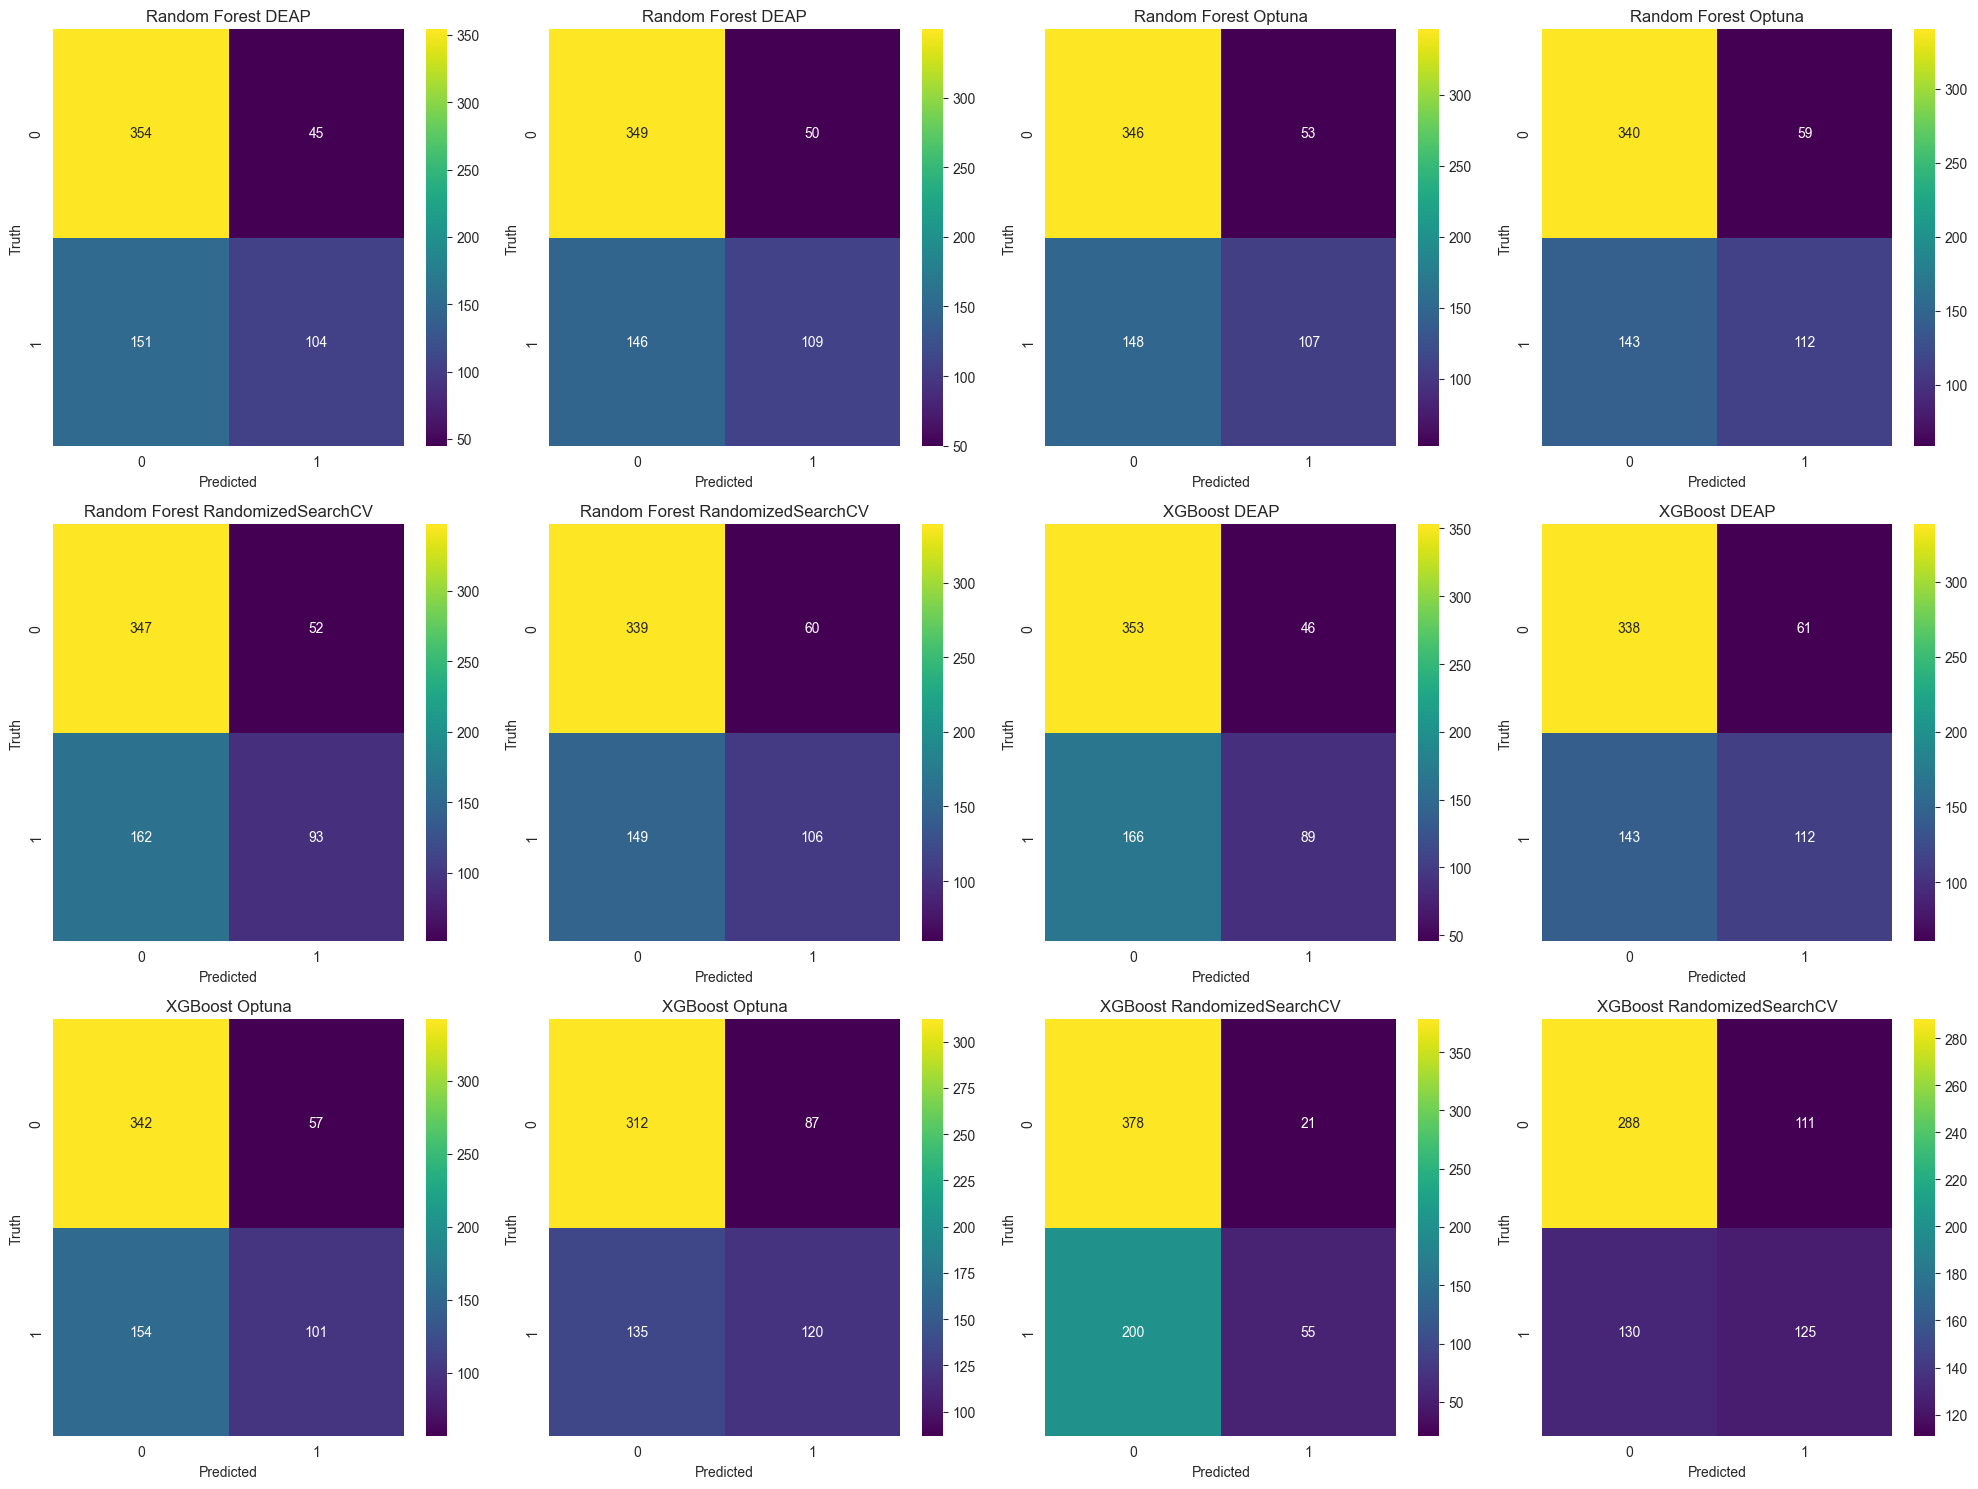

In [62]:
fig, axs = plt.subplots(3, 4, figsize=(20,15))

for i, model in enumerate(models):
    plot_model_confusion_matrix(axs[i//4, i%4], model.model, model.test_set, model.test_label, f'{model.classifier_name} {model.optimization_method}')

plt.tight_layout()
plt.show()

### Ogólna tabela wyników po optymalizacji

In [63]:
data = []
for model in models:
    data.append([model.classifier_name, model.optimization_method, model.best_score, model.best_score_type, model.best_params, model.processing_time])

optimized_results_df = pd.DataFrame(data, columns=['Model Name', 'Optimization Method', 'Best Score', 'Score Type', 'Best Parameters', 'Processing Time [s]'])
    
optimized_results_df

,Model Name,Optimization Method,Best Score,Score Type,Best Parameters,Processing Time [s]
0,Random Forest,DEAP,0.700306,accuracy,"{'n_estimators': 195, 'max_depth': 25, 'min_sa...",532.291090
1,Random Forest,DEAP,0.653665,F1 score,"{'n_estimators': 186, 'max_depth': 24, 'min_sa...",765.684987
2,Random Forest,Optuna,0.692661,accuracy,"{'n_estimators': 30, 'max_depth': 41, 'min_sam...",45.247323
3,Random Forest,Optuna,0.648398,F1 score,"{'n_estimators': 100, 'max_depth': 22, 'min_sa...",51.028044
4,Random Forest,RandomizedSearchCV,0.672783,accuracy,"{'n_estimators': 138, 'max_depth': 40, 'min_sa...",10.417568
5,Random Forest,RandomizedSearchCV,0.633969,F1 score,"{'n_estimators': 106, 'max_depth': 35, 'min_sa...",14.448170
6,XGBoost,DEAP,0.675841,accuracy,"{'n_estimators': 91, 'max_depth': 16, 'min_chi...",46.428532
7,XGBoost,DEAP,0.645773,F1 score,"{'n_estimators': 184, 'max_depth': 28, 'min_ch...",29.438541
8,XGBoost,Optuna,0.677370,accuracy,"{'n_estimators': 106, 'max_depth': 5, 'min_chi...",5.633968
9,XGBoost,Optuna,0.628535,F1 score,"{'n_estimators': 78, 'max_depth': 34, 'min_chi...",5.572183


### Najlepszy wynik modeli Random Forest i XGBoost przed optymalizacją

In [64]:
with open('data_dump/resultsBeforeOptimization.pkl', 'rb') as f:
    results_df = pickle.load(f)

filtered_df_before_opt = results_df.loc[(results_df['Model'].isin(['Random Forest', 'XGBoost'])) & (results_df['Normalization'] == 'Std') & (results_df['Missing Data'] == 'Interpolate')]
filtered_df_before_opt = filtered_df_before_opt.drop(columns=['Normalization', 'Missing Data'])

filtered_df_before_opt

,Model,Accuracy,F1
8,Random Forest,0.669725,0.605430
20,XGBoost,0.651376,0.591716


### Najlepszy wynik modeli Random Forest i XGBoost po optymalizacji

In [65]:
best_accuracy_RF_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'Random Forest') & (optimized_results_df['Score Type'] == 'accuracy')].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_RF_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'Random Forest') & (optimized_results_df['Score Type'] == 'F1 score')].sort_values(by='Best Score', ascending=False).iloc[0]
best_accuracy_XGB_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'XGBoost') & (optimized_results_df['Score Type'] == 'accuracy')].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_XGB_row = optimized_results_df.loc[(optimized_results_df['Model Name'] == 'XGBoost') & (optimized_results_df['Score Type'] == 'F1 score')].sort_values(by='Best Score', ascending=False).iloc[0]

best_rows = pd.concat([best_accuracy_RF_row, best_f1score_RF_row, best_accuracy_XGB_row, best_f1score_XGB_row], axis=1).transpose()
best_rows

,Model Name,Optimization Method,Best Score,Score Type,Best Parameters,Processing Time [s]
0,Random Forest,DEAP,0.700306,accuracy,"{'n_estimators': 195, 'max_depth': 25, 'min_sa...",532.29109
1,Random Forest,DEAP,0.653665,F1 score,"{'n_estimators': 186, 'max_depth': 24, 'min_sa...",765.684987
8,XGBoost,Optuna,0.67737,accuracy,"{'n_estimators': 106, 'max_depth': 5, 'min_chi...",5.633968
7,XGBoost,DEAP,0.645773,F1 score,"{'n_estimators': 184, 'max_depth': 28, 'min_ch...",29.438541


### Porównanie wyników przed i po optymalizacji dla modeli Random Forest i XGBoost

In [72]:
final_data = {
    "Model Name": ['Random Forest', 'XGBoost'],
    "Before Optimization Accuracy": [filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'Accuracy'].values[0],
                                    filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'Accuracy'].values[0]],
    "After Optimization Accuracy": [best_accuracy_RF_row['Best Score'], best_accuracy_XGB_row['Best Score']],
    "Difference Accuracy": [best_accuracy_RF_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'Accuracy'].values[0],
                            best_accuracy_XGB_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'Accuracy'].values[0]],  
    "Before Optimization F1 Score": [filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'F1'].values[0],
                                    filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'F1'].values[0]],
    "After Optimization F1 Score": [best_f1score_RF_row['Best Score'], best_f1score_XGB_row['Best Score']],
    "Difference F1 Score": [best_f1score_RF_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'Random Forest', 'F1'].values[0],
                            best_f1score_XGB_row['Best Score'] - filtered_df_before_opt.loc[filtered_df_before_opt['Model'] == 'XGBoost', 'F1'].values[0]]
}

final_results_df = pd.DataFrame(final_data)
final_results_df

,Model Name,Before Optimization Accuracy,After Optimization Accuracy,Difference Accuracy,Before Optimization F1 Score,After Optimization F1 Score,Difference F1 Score
0,Random Forest,0.669725,0.700306,0.030581,0.605430,0.653665,0.048235
1,XGBoost,0.651376,0.677370,0.025994,0.591716,0.645773,0.054058


### Wybranie najlepszego modelu

In [77]:
best_accuracy_model = optimized_results_df.loc[optimized_results_df['Score Type'] == 'accuracy'].sort_values(by='Best Score', ascending=False).iloc[0]
best_f1score_model = optimized_results_df.loc[optimized_results_df['Score Type'] == 'F1 score'].sort_values(by='Best Score', ascending=False).iloc[0]

#### Najlepszy model pod kątem Accuracy

In [81]:
best_accuracy_model

Model Name                                                 Random Forest
Optimization Method                                                 DEAP
Best Score                                                      0.700306
Score Type                                                      accuracy
Best Parameters        {'n_estimators': 195, 'max_depth': 25, 'min_sa...
Processing Time [s]                                            532.29109
Name: 0, dtype: object

#### Najlepszy model pod kątem F1 Score

In [82]:
best_f1score_model

Model Name                                                 Random Forest
Optimization Method                                                 DEAP
Best Score                                                      0.653665
Score Type                                                      F1 score
Best Parameters        {'n_estimators': 186, 'max_depth': 24, 'min_sa...
Processing Time [s]                                           765.684987
Name: 1, dtype: object

### Macierze pomyłek dla najlepszych modeli pod kątem accuracy i F1 Score

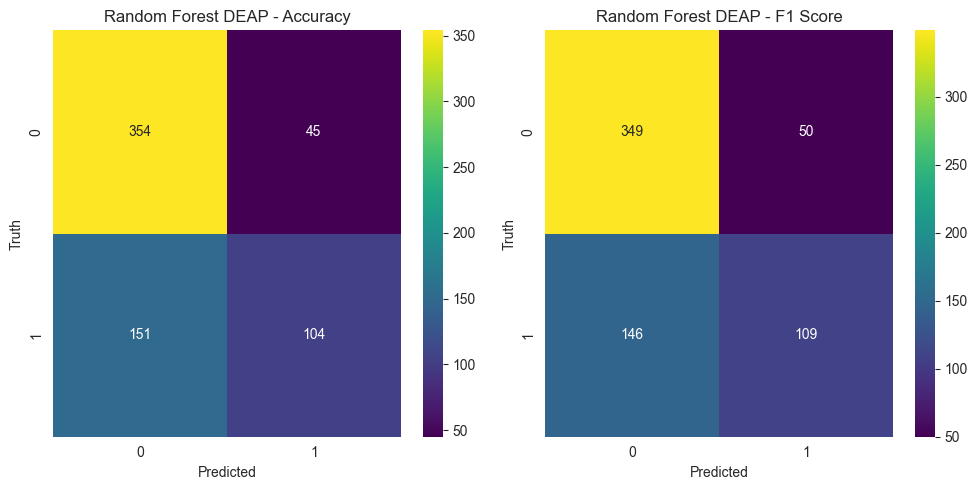

In [83]:
models_sorted_by_accuracy = sorted(models, key=lambda x: x.best_score if x.best_score_type == "accuracy" else 0, reverse=True)
best_accuracy_models = models_sorted_by_accuracy[:1]

models_sorted_by_f1 = sorted(models, key=lambda x: x.best_score if x.best_score_type == "F1 score" else 0, reverse=True)
best_f1_models = models_sorted_by_f1[:1]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plot_model_confusion_matrix(axs[0], best_accuracy_models[0].model, best_accuracy_models[0].test_set, best_accuracy_models[0].test_label, f'{best_accuracy_models[0].classifier_name} {best_accuracy_models[0].optimization_method} - Accuracy')
plot_model_confusion_matrix(axs[1], best_f1_models[0].model, best_f1_models[0].test_set, best_f1_models[0].test_label, f'{best_f1_models[0].classifier_name} {best_f1_models[0].optimization_method} - F1 Score')

plt.tight_layout()
plt.show()